In [10]:
import sys
import numpy as np
import cv2
!pip install opencv-python

In [54]:
model = 'yolo_v3/yolov3.weights'
config = 'yolo_v3/yolov3.cfg'
class_labels = 'yolo_v3/coco.names'
confThreshold = 0.5
nmsThreshold = 0.4

In [55]:
cap = cv2.VideoCapture('station4.avi')#

In [56]:
net = cv2.dnn.readNet(model, config)

In [57]:
classes = []
with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [58]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [59]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [60]:
if not cap.isOpened():
    print("Video open failed!")
# 실행
else :    
    #이미지 프레임 사이즈값을 받습니다.
    w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #전체 프레임 수값을 받습니다.
    frame_cnt = round(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #초당 프레임 값을받습니다.
    fps = cap.get(cv2.CAP_PROP_FPS)
    #한 프레임당 걸리는 시간을 받습니다.
    delay = int(1000 / fps)
    #영상을 저장할 코덱정보를 저장합니다.
    fourcc = cv2.VideoWriter_fourcc(*'DIVX') # *'DIVX' == 'D', 'I', 'V', 'X'
    #영상을 저장할 이름을 지정합니다.
    outputVideo = cv2.VideoWriter('junekoo.avi', fourcc, fps, (w, h))
    
    
    #전체 프레임까지 영상 루프를 돌립니다.
    for i in range(frame_cnt): 
        ret, frame = cap.read()
        #매 프레임마다 얼굴 검출
        if not ret:
            break
        #각 프레임번째 수를 화면에 함께 출력해 알려줄 것입니다.    
        label2='%d'%(i)
        
        #원본 이미지가 너무 크므로 가로세로 절반씩 리사이즈 해줬습니다. 보기편하게 하기 위해서 입니다.
        #h, w = frame.shape[:2]
        #frame = cv2.resize(frame, (w//2, h//2))
        
        # 블롭 생성 & 추론 #RGB하니까 True로 !
        blob = cv2.dnn.blobFromImage(frame, 1/255., (320, 320), swapRB=True)

        net.setInput(blob)
        outs = net.forward(output_layers)
        #forward해주고 문자열 리스트를 넣어줍니다.  outs를 리턴

        # outs는 3개의 ndarray 리스트.
        # outs[0].shape=(507, 85), 13*13*3=507
        # outs[1].shape=(2028, 85), 26*26*3=2028
        # outs[2].shape=(8112, 85), 52*52*3=8112

        h, w = frame.shape[:2]

        class_ids = []
        confidences = []
        boxes = []
        
        #outs에 있는 ndarray를 다 체크하는데 하나의 행은 85개짜리의 elements, 좌표(4)+objectscore(1)+확률(80)
        for out in outs:
            for detection in out:
                # detection: 4(bounding box) + 1(objectness_score) + 80(class confidence)
                scores = detection[5:]
                #80개에서 5번째 최대값위치의 id값을 뽑아와서 그 위치에서의 confidence를 체크합니다.
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > confThreshold:
                    #확률이 0.5이상이면 바운딩박스를 취합니다.
                    # 바운딩 박스 중심 좌표 & 박스 크기
                    #0~1사이로 노말라이제이션 되어있어서 w,h를 곱해줘야합니다.
                    cx = int(detection[0] * w)
                    cy = int(detection[1] * h)
                    bw = int(detection[2] * w)
                    bh = int(detection[3] * h)

                    # center 좌표로 바운딩 박스 좌상단 좌표추출
                    sx = int(cx - bw / 2)
                    sy = int(cy - bh / 2)

                    boxes.append([sx, sy, bw, bh])
                    #좌표를 묶어서 boxes에 쟁여놓습니다.
                    confidences.append(float(confidence))
                    class_ids.append(int(class_id))
                    #일단 confidences와 class에 쟁여놓습니다..
                    #겹치는게 생기는데 그중 좋은걸 쓸거다 비최대억제에서

        # 비최대 억제
        #boxes,confidence에서 스레시홀드가 0.4이상으로 되는걸 골라서(박스가 40%정도 겹친다). 그중에서 confidence가 0.5이상인것들 중에서 가장큰 confidence를 indices에다가 넣어준다.
        indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
        #몇번째 박스를 쓸거인지가 저장된다.

        for i in indices:#N행1열
            i = i[0]
            sx, sy, bw, bh = boxes[i] #i번째 박스정보를 다시 가져옵니다.
            label = f'{classes[class_ids[i]]}: {confidences[i]:.2}'
            #문자열과 confidence 가져와서 아래에 출력합니다.
            color = colors[class_ids[i]]
            cv2.rectangle(frame, (sx, sy, bw, bh), color, 2)
            cv2.putText(frame, label, (sx, sy - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

        t, _ = net.getPerfProfile()
        #인퍼런스시킬때 시간을 알아서 측정해줍니다. 실행하는데 시간이 얼마큼 걸렸다를 화면 좌측상단에 표시해 줍
        
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 0, 255), 1, cv2.LINE_AA)
        frame=cv2.putText(frame,label2 , (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
        
        #허프만 
        frame2 = cv2.inRange(frame, (0, 150, 150), (150, 255, 255))#Yellow RGB 로 설정
        
        lines = cv2.HoughLinesP(frame2, 1, np.pi / 180., 160, minLineLength=300, maxLineGap=5)
        #1번째 인자 : edges
        #2번째 인자 : rho로 1픽셀간격으로 한다. 보통 기본값
        #3번째 인자 : 각도는 1도단위. 보통 기본값
        #4번째 인자 : threshold는 160정도
        #5번째 인자 : 최소길이 50
        #6번째 인자 : 5픽셀정도는 떨어져도 이어라
        
        #frame=cv2.cvtColor(frame,cv2.COLOR_GRAY2BGR)#다시 컬러영상으로 변환. 저장하기 위해 실제로는 할필요없음
        #frame = cv2.GaussianBlur(frame2, (0, 0), 1) #노이즈 완화
        
        if lines is not None:#혹시 라인이 하나도 검출이 안될수 있다.
            for j in range(lines.shape[0]):#shape의 첫번째가 직선성분의 개수
                pt1 = (lines[j][0][0], lines[j][0][1])  # 시작점 좌표 x,y
                pt2 = (lines[j][0][2], lines[j][0][3])  # 끝점 좌표 x,y
                #가운데 인자는 무조건 0이다. 더미개념
                cv2.line(frame, pt1, pt2, (0, 0, 255), 2, cv2.LINE_AA)
                
        cv2.imshow('frame', frame)
        outputVideo.write(frame)
        cv2.waitKey(delay)
        if cv2.waitKey(1) == 27:
            break
            
outputVideo.release()
cap.release()
cv2.destroyAllWindows()

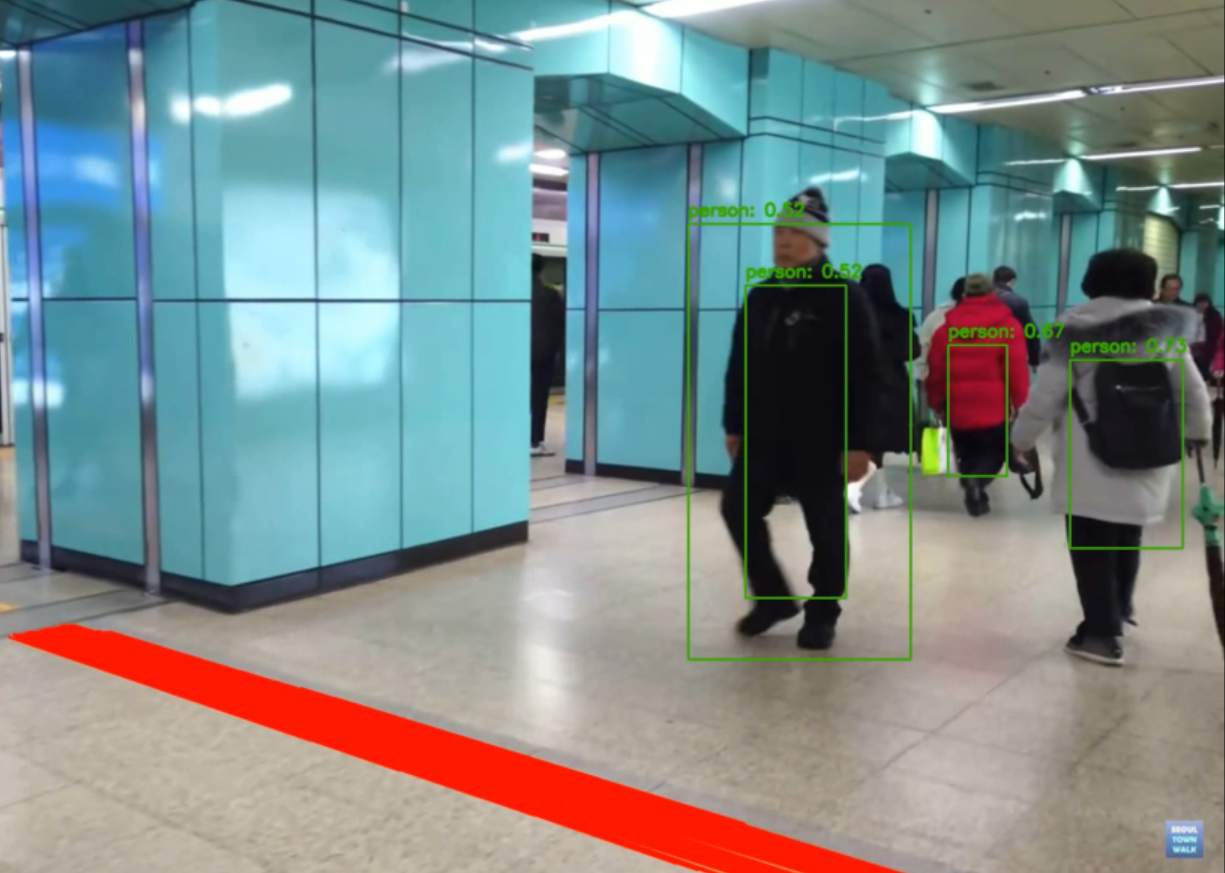